importing the dependencies

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Load the dataset

In [60]:
big_mart_data = pd.read_csv("/content/drive/MyDrive/self_projects/big_mart_sales/Train.csv")
big_mart_data.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

EDA (Exploratory Data Analysis)

In [61]:
# checking the shape of the dataframe
big_mart_data.shape

(8523, 12)

In [62]:
# checking the list of columns
big_mart_data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [63]:
# checking for the data type of different columns
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Categorical features:
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type

In [64]:
# identifying missing values in respective columns
big_mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [65]:
# imputation of missing values
big_mart_data["Item_Weight"].fillna(big_mart_data["Item_Weight"].mean(), inplace=True) # since it has continous numerical value, that's where mean or median is used


In [66]:
# since Outlet_Size is a categorical feature so we will be using mode
# but not mode of the Outlet_Size column but mode of a feature which is correlated to Outlet_Size column
# it is seen that Outlet_Type is correlated to Outlet_Size
# for that we will use pivot table

In [67]:
mode_of_outlet_size = big_mart_data.pivot_table(values="Outlet_Size", columns="Outlet_Type", aggfunc=(lambda x: x.mode()[0]))
# values parameter represents that column having missing values
# columns parameter represents that column upon which the aggregate function will be applied (here it is mode)

In [68]:
print(mode_of_outlet_size)
# it is printing a pivot table
# it is seen that in most of the cases:
# when Outlet_Type is Grocery Store, Outlet_Size is Small
# when Oultet_Type is Supermarket Type1, Outlet_Size is small
# when Outlet_Type is Supermarket Type2, Outlet_Size is medium
# when Oultet_Type is Supermarket Type3, Outlet_Size is medium

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [69]:
missing_values = big_mart_data["Outlet_Size"].isnull()

In [70]:
print(missing_values)

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [86]:
# replacing the missing values with the one which corresponds to the Outlet_Type
# missing_values represents the rows and "Outlet_Size"/"Outlet_Type" represents the columns
# now we apply lambda function over each row with column as "Outlet_Type"
big_mart_data.loc[missing_values, "Outlet_Size"] = big_mart_data.loc[missing_values, "Outlet_Type"].apply(lambda x: mode_of_outlet_size[x])

In [87]:
# checking again whether the dataset has missing values or not
big_mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [88]:
big_mart_data.describe() # shows the statistical features(will be displayed only for numerical values only)

Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  8523.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.226124         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       9.310000         0.026989    93.826500                1987.000000   
50%      12.857645         0.053931   143.012800                1999.000000   
75%      16.000000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800

Data visualization

In [89]:
sns.set() # sets a theme for our visualization

- for numerical features we use distplot
- for categorical features we use countplot

In [90]:
# item_weight distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data["Item_Weight"])
plt.show() # it is well distributed with a few dips

<ipython-input-90-2b7c560653cc>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data["Item_Weight"])


<ipython-input-91-2b7a3f9b1719>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data["Item_Visibility"])


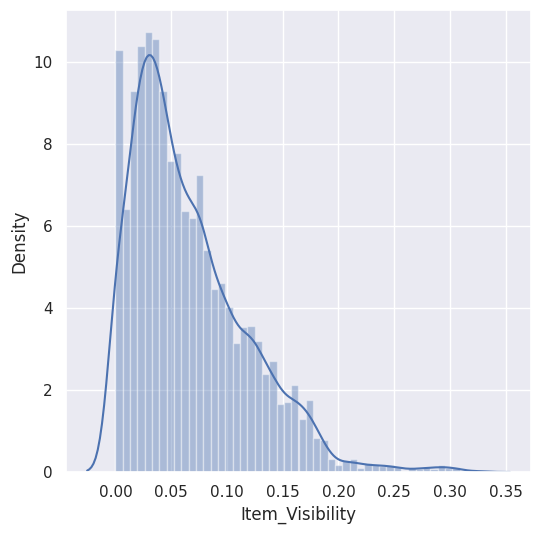

In [91]:
# item_visibility distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data["Item_Visibility"])
plt.show() # the distribution is skewed to the right (-ve skewness)

<ipython-input-92-e7c6abbda752>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data["Item_MRP"])


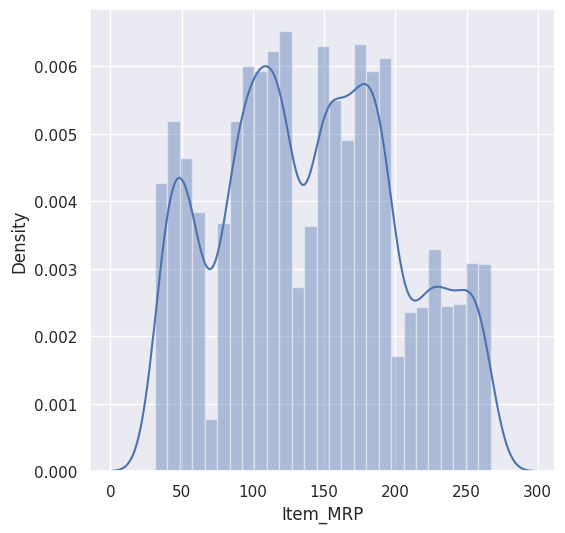

In [92]:
# Item_MRP distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data["Item_MRP"])
plt.show() # we can that there are multiple peak in terms of MRP

<ipython-input-93-dd90627c5273>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data["Item_Outlet_Sales"])


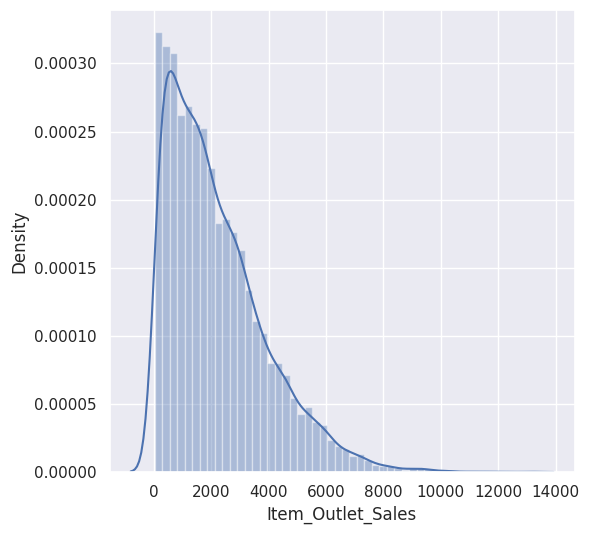

In [93]:
# Item_Outlet_Sales distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data["Item_Outlet_Sales"])
plt.show() # left skewd graph

<ipython-input-94-4fb1346afd59>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Outlet_Establishment_Year", data=big_mart_data, palette=["#432371", "#FAAE7B", "#7fcdbb"])
<ipython-input-94-4fb1346afd59>:3: UserWarning: 
The palette list has fewer values (3) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x="Outlet_Establishment_Year", data=big_mart_data, palette=["#432371", "#FAAE7B", "#7fcdbb"])


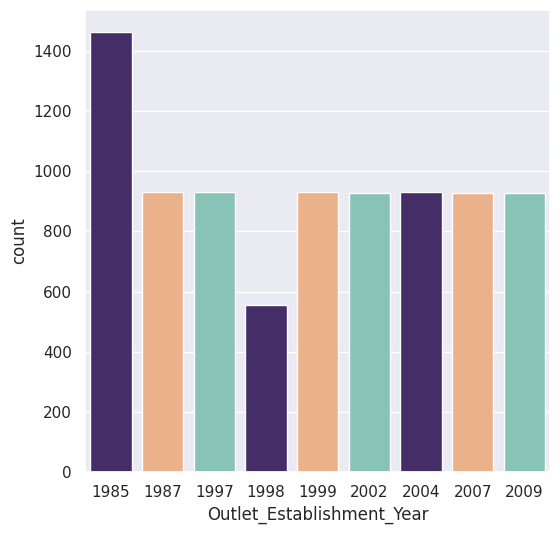

In [94]:
# Outlet_Establishment_Year distribution
plt.figure(figsize=(6,6))
sns.countplot(x="Outlet_Establishment_Year", data=big_mart_data, palette=["#432371", "#FAAE7B", "#7fcdbb"])
plt.show()

<ipython-input-95-33583ee71ad6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Item_Fat_Content", data=big_mart_data, palette=["#432371", "#FAAE7B", "#7fcdbb"])
<ipython-input-95-33583ee71ad6>:3: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x="Item_Fat_Content", data=big_mart_data, palette=["#432371", "#FAAE7B", "#7fcdbb"])


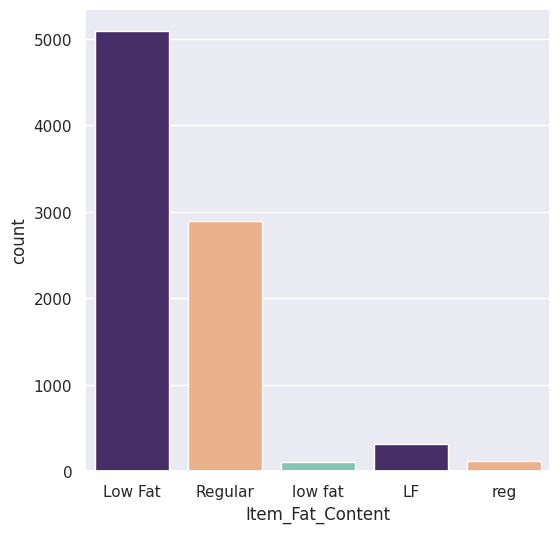

In [95]:
# Item_Fat_content column
plt.figure(figsize=(6,6))
sns.countplot(x="Item_Fat_Content", data=big_mart_data, palette=["#432371", "#FAAE7B", "#7fcdbb"])
plt.show()

<ipython-input-96-c1e18c11ba20>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Item_Type", data=big_mart_data, palette="Set2")


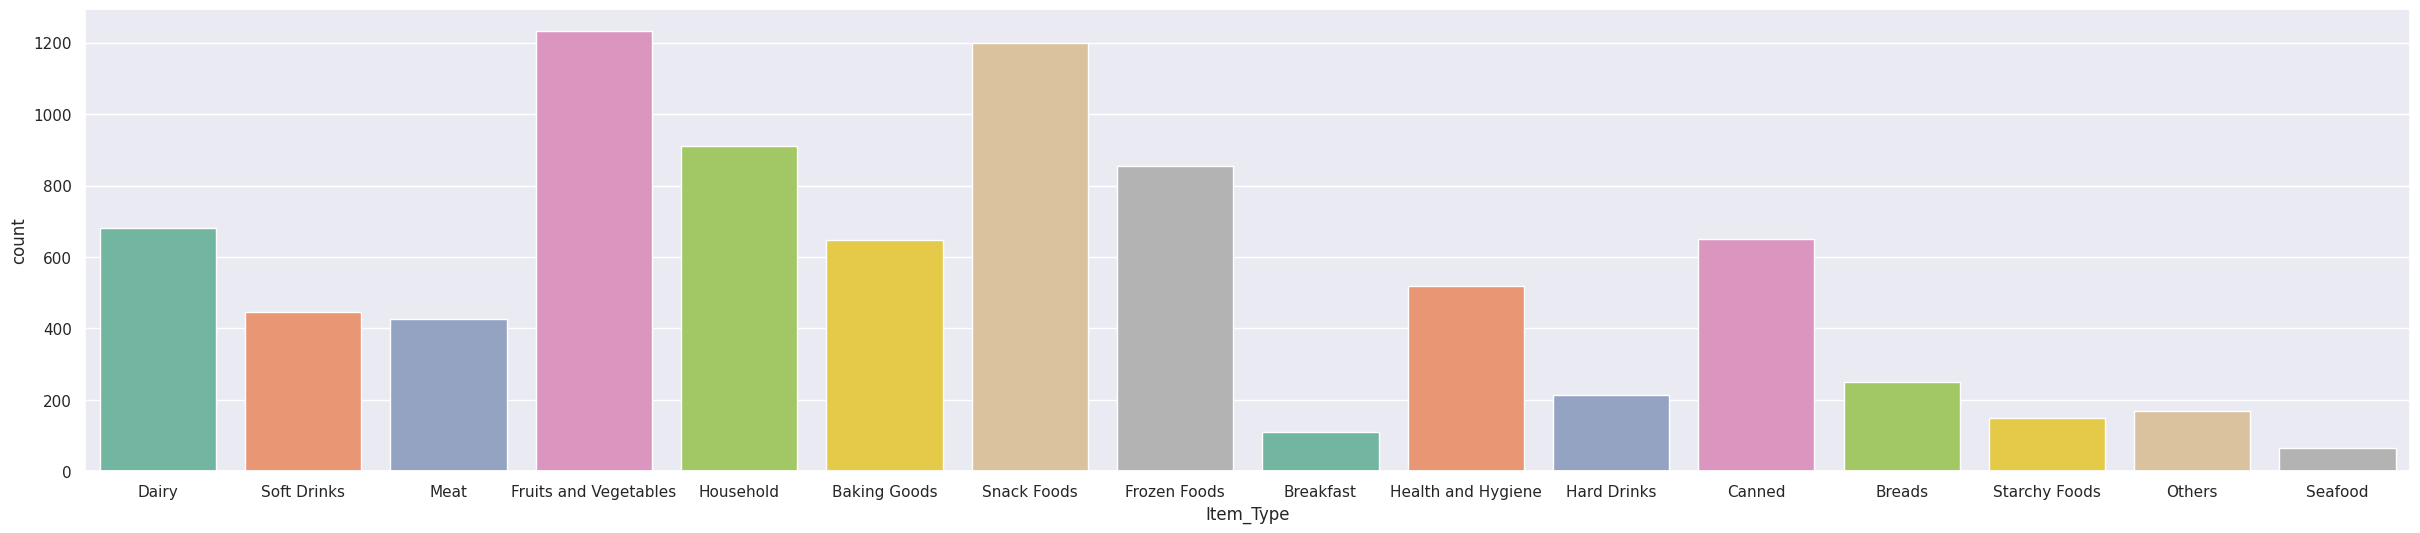

In [96]:
# Item_Type distribution
plt.figure(figsize=(30,6))
sns.countplot(x="Item_Type", data=big_mart_data, palette="Set2")
plt.show()

<ipython-input-99-c022aa190656>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Outlet_Size", data=big_mart_data, palette="Set2")


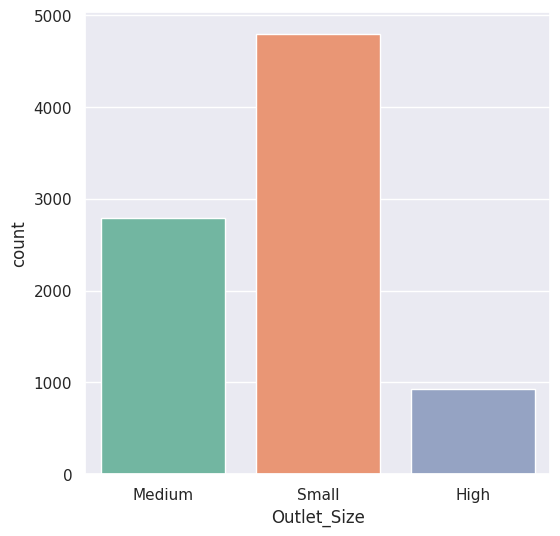

In [99]:
# Outlet_Size distribution
plt.figure(figsize=(6,6))
sns.countplot(x="Outlet_Size", data=big_mart_data, palette="Set2")
plt.show()

<ipython-input-100-5a896c92d5d9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Outlet_Location_Type", data=big_mart_data, palette="Set2")


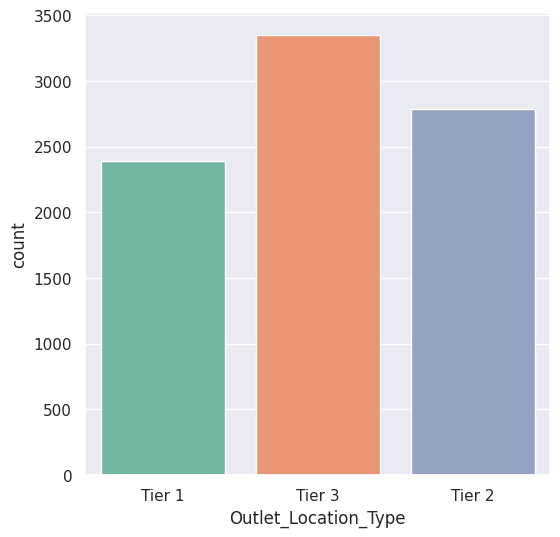

In [100]:
# Outlet_Location_Type distribution
plt.figure(figsize=(6,6))
sns.countplot(x="Outlet_Location_Type", data=big_mart_data, palette="Set2")
plt.show()

<ipython-input-102-ad3b913f4d85>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Outlet_Type", data=big_mart_data, palette="Set2")


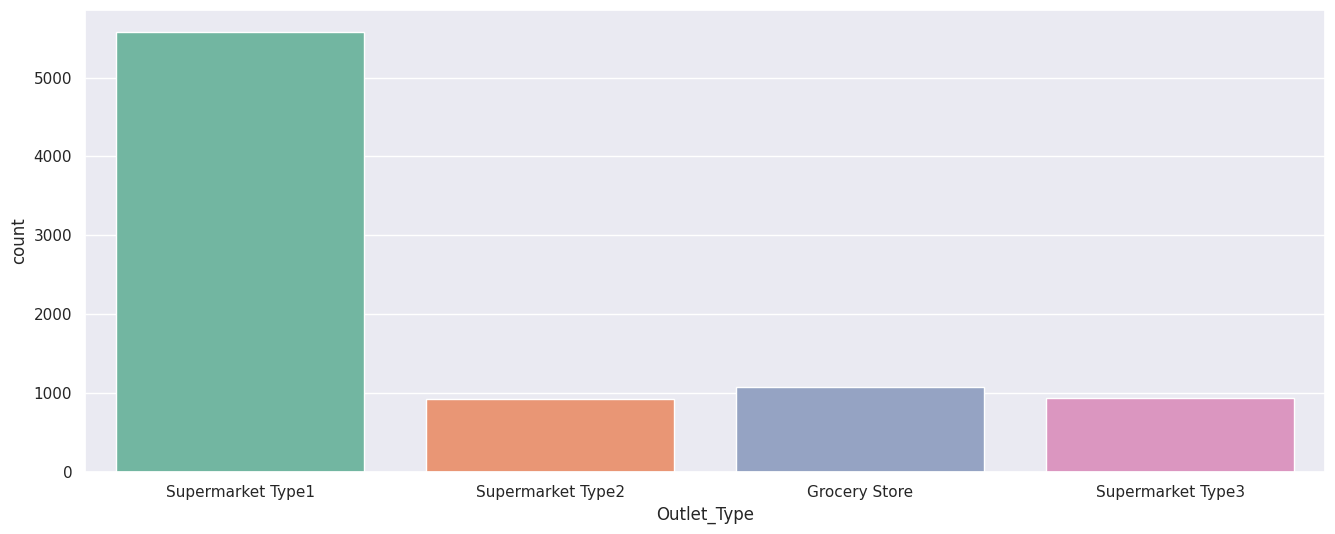

In [102]:
# Outlet_Type distribution
plt.figure(figsize=(16,6))
sns.countplot(x="Outlet_Type", data=big_mart_data, palette="Set2")
plt.show()

Data preprocessing

In [105]:
big_mart_data.replace({"Item_Fat_Content":{"Low Fat": "Low fat", "LF": "Low fat", "reg": "Regular"}}, inplace=True)

In [107]:
# encoding the categorical (textual) data to numerical values
encoder = LabelEncoder()

In [117]:
big_mart_data["Item_Fat_Content"] = encoder.fit_transform(big_mart_data["Item_Fat_Content"])
big_mart_data["Item_Type"] = encoder.fit_transform(big_mart_data["Item_Type"])
big_mart_data["Outlet_Identifier"] = encoder.fit_transform(big_mart_data["Outlet_Identifier"])
big_mart_data["Outlet_Size"] = encoder.fit_transform(big_mart_data["Outlet_Size"])
big_mart_data["Outlet_Location_Type"] = encoder.fit_transform(big_mart_data["Outlet_Location_Type"])
big_mart_data["Outlet_Type"] = encoder.fit_transform(big_mart_data["Outlet_Type"])
big_mart_data["Item_Identifier"] = encoder.fit_transform(big_mart_data["Item_Identifier"])

Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  Item_Type  \
0              156         9.30                 0         0.016047          4   
1                8         5.92                 1         0.019278         14   
2              662        17.50                 0         0.016760         10   
3             1121        19.20                 1         0.000000          6   
4             1297         8.93                 0         0.000000          9   

   Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  Outlet_Size  \
0  249.8092                  9                       1999            1   
1   48.2692                  3                       2009            1   
2  141.6180                  9                       1999            1   
3  182.0950                  0                       1998            2   
4   53.8614                  1                       1987            0   

   Outlet_Location_Type  Outlet_Type  Item_Outlet_Sales  
0                     0            1          3735.1380  
1                     2            2           443.4228  
2                     0            1          2097.2700  
3                     2            0           732.3800  
4                     2            1           994.7052

Splitting the data features and output label

In [118]:
X = big_mart_data.drop(columns="Item_Outlet_Sales", axis=1)
y = big_mart_data["Item_Outlet_Sales"]

Splitting the data into training and testing data

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

Model training

In [120]:
model = XGBRegressor()

In [121]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Model prediction

In [122]:
# training data
train_data_pred = model.predict(X_train)
# testing data
test_data_pred = model.predict(X_test)

Model evaluation

In [124]:
r2_train = metrics.r2_score(y_train, train_data_pred)
r2_test = metrics.r2_score(y_test, test_data_pred)

In [126]:
print("r2 score of the training data: ", r2_train) # overfitting is observed
print("r2 score of the testing data: ", r2_test)

r2 score of the training data:  0.8789553386204404
r2 score of the testing data:  0.5135187880373824
